###### Helper Functions

In [ ]:
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt

urls = [ # note comments are in reverse order
    'https://i.ibb.co/85B0DH5/image.png', #gradient2
    'https://i.ibb.co/LRKKz1b/image.png', #gradient
    'https://i.ibb.co/x56c4gV/imageA.png', #flower
    'https://i.ibb.co/jZqW0vs/imageB.png', # many leaves
    'https://i.ibb.co/f2wpKHb/grey-4.png', #panda
    'https://i.ibb.co/9814MPs/grey-3.png', #girl
    'https://i.ibb.co/gMBq0vb/grey-2.png', #houses
    'https://i.ibb.co/0fLbXtt/grey-1.png' #elon
][::-1]

imgs_ = [
    cv2.imdecode(
        np.asarray(
            bytearray(
                requests.get(url).content
                ),
            dtype="uint8"
            ),1
        )
    for url in urls
]
imgs = [cv2.cvtColor(i,cv2.COLOR_BGR2GRAY) for i in imgs_]
dataset = imgs[:4]

def show_images(i1,i2,i3,i4):
  plt.rcParams["figure.figsize"] = (17,5)
  plt.subplot(1,4,1)
  plt.imshow(i1,cmap = plt.cm.gray)
  plt.axis('off')
  plt.tight_layout()
  plt.subplot(1,4,2)
  plt.imshow(i2,cmap = plt.cm.gray)
  plt.axis('off')
  plt.tight_layout()
  plt.subplot(1,4,3)
  plt.imshow(i3,cmap = plt.cm.gray)
  plt.axis('off')
  plt.tight_layout()
  plt.subplot(1,4,4)
  plt.imshow(i4,cmap = plt.cm.gray)
  plt.axis('off')
  plt.tight_layout()
  plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

def show_two(i1,i2):
  plt.subplot(1,2,1)
  plt.imshow(i1,cmap = plt.cm.gray)
  plt.subplot(1,2,2)
  plt.imshow(i2,cmap = plt.cm.gray)

def show_comparison(i1):
  print()
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.axis('off')
  plt.imshow(i1,cmap=plt.cm.gray)
  plt.tight_layout()
  plt.subplot(1,2,2)
  plt.title('Equalized Image')
  plt.axis('off')
  plt.imshow(get_equalized_image(i1),cmap=plt.cm.gray)
  plt.tight_layout()
  plt.suptitle('Comparing the original and the equalized image')
  plt.show()

def matched(i1,i2):
  _,_,cumsum1,_ = get_equalized_hist(i1)
  _,_,cumsum2,_ = get_equalized_hist(i2)
  # cumsum1 = np.array(list(cumsum1.values()))
  # cumsum2 = np.array(list(cumsum2.values()))
  # print(cumsum1.shape)
  # matching_map = [0]*256
  matching_map = {}
  # for i in range(256):
  #   matching_map[i] = np.argmin(np.abs(cumsum2-cumsum1[i]))

  for k1, v1 in cumsum1.items():
      min_diff = np.inf
      closest = None
      for k2, v2 in cumsum2.items():
          diff = abs(v1 - v2)
          if diff < min_diff:
              min_diff = diff
              closest = k2
      matching_map[k1] = closest

  matched_img = np.zeros(i1.shape)
  l,b = matched_img.shape
  for i in range(l):
    for j in range(b):
      matched_img[i,j] = matching_map[i1[i,j]]
  return matched_img

# Lab Assignment 5
## Histogram Equalization and Matching
#### - Jaskirat Singh Maskeen (23110146)
### Histogram Equalizatation:
It is a technique using which we can improve the contrast of images. The main idea is to flatten the pixel intensity distribution, so that every intensity has roughly the same number of pixels.

We are using grayscale images so for our convinience but the same technique can be applied to colored images as well. In colored images, we will have three channels R, G, B for red, green and blue respectively.

If the CDF (Cumilative Density Function) has a steep slope near some intensity values, that means there are a lot of pixels near that intensity. We then scale this CDF to be between 0 and 255 (for 8 bit grayscale images) so that we can approximate to a uniform CDF.


###### Functions for generating histogram, generating equalized histogram and getting the image from the equalized histogram.

In [ ]:
def get_histogram(img):
  # tt = cv2.calcHist([img],[0],None,[256],[0,256])
  m = {d:0 for d in range(0,256)}
  l,b = img.shape
  for i in range(l):
    for j in range(b):
      m[img[i,j]]+=1
  return m

def get_equalized_hist(i1):
  intensity_num_of_pixel_map = get_histogram(i1)
  num_pixels = list(intensity_num_of_pixel_map.values())
  cumsum = np.cumsum(num_pixels)
  total_pixels = cumsum.max()
  cdf_pixel_map = {}
  cumsum_pixel_map = {}
  cdf_scaled_map = {}
  for i in range(0,256):
    cdf_pixel_map[i] = cumsum[i]/total_pixels
    cdf_scaled_map[i] = round(cumsum[i]*255/total_pixels)
    cumsum_pixel_map[i] = cumsum[i]

  equalized_hist={d:0 for d in range(0,256)}

  for k,v in cdf_scaled_map.items():
    equalized_hist[v]+=intensity_num_of_pixel_map[k]
  return intensity_num_of_pixel_map,equalized_hist,cumsum_pixel_map,cdf_scaled_map

def get_equalized_image(img):
  original_hist,equalized_hist,cumsum_overall,new_positions = get_equalized_hist(img)
  new_img = np.zeros(img.shape)
  l,b = new_img.shape
  for i in range(l):
    for j in range(b):
      new_img[i,j] = new_positions[img[i,j]]
  return new_img

def get_gradient():
  a = b = f = np.zeros((512,512),'uint8')
  for i in range(512):
    a[i] = np.linspace(0,255,512,dtype='uint8')
  for i in range(512):
    b[:,i] = np.linspace(0,255,512,dtype='uint8')[::-1]
  for i in range(512):
    for j in range(512):
      v1 = a[j,i]
      v2 = b[j,i]
      f[i,j] = max(v1,v2)
  return f

###### Seeing the effect of Histogram equalization
Consider the follwing image, generated using the `get_gradient()` function.

<img src="https://i.ibb.co/85B0DH5/image.png" width="300" height="300" />


###### The histogram and the cdf for this image will be:

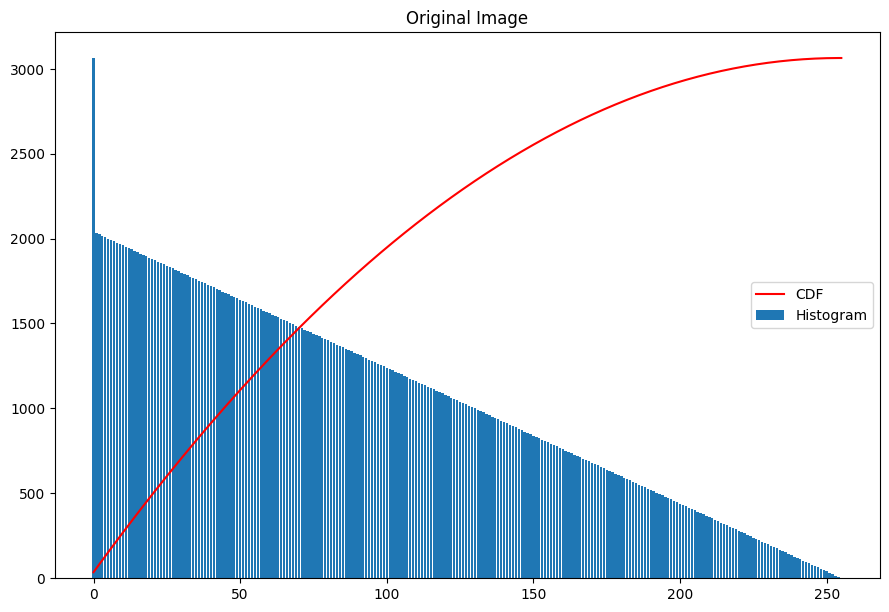

In [ ]:
# @title Histogram and CDF for gradient
hist,eqhist,og_cdf,scaled_cdf = get_equalized_hist(get_gradient())
plt.rcParams["figure.figsize"] = (9,6)
plt.bar(hist.keys(),hist.values(),label='Histogram')
plt.plot(og_cdf.keys(),np.array(list(og_cdf.values()))/max(og_cdf.values())*max(hist.values()),label = 'CDF',color='red')
plt.tight_layout()
plt.legend()
plt.title('Original Image')
plt.show()

###### Now after equalizing the histogram, we would get the image as shown along with the equalized histogram:

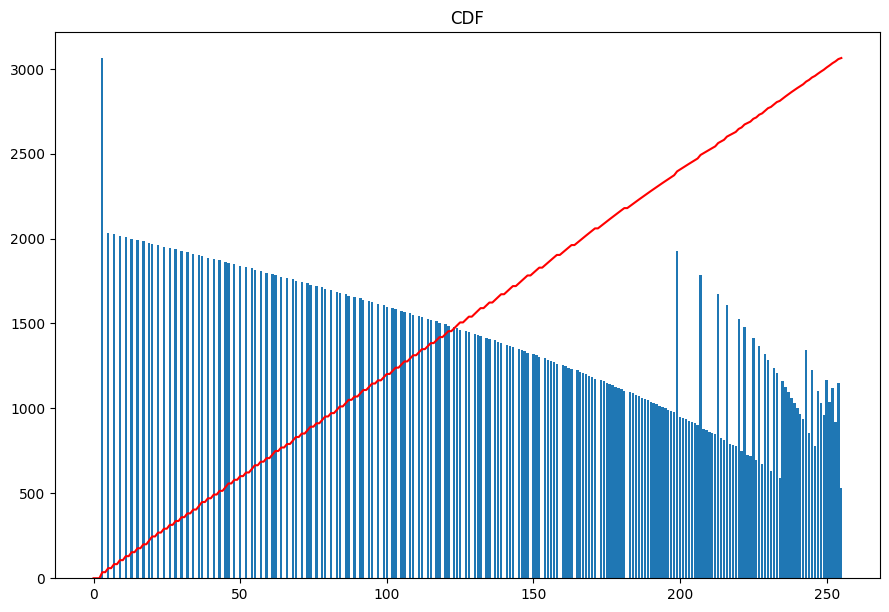

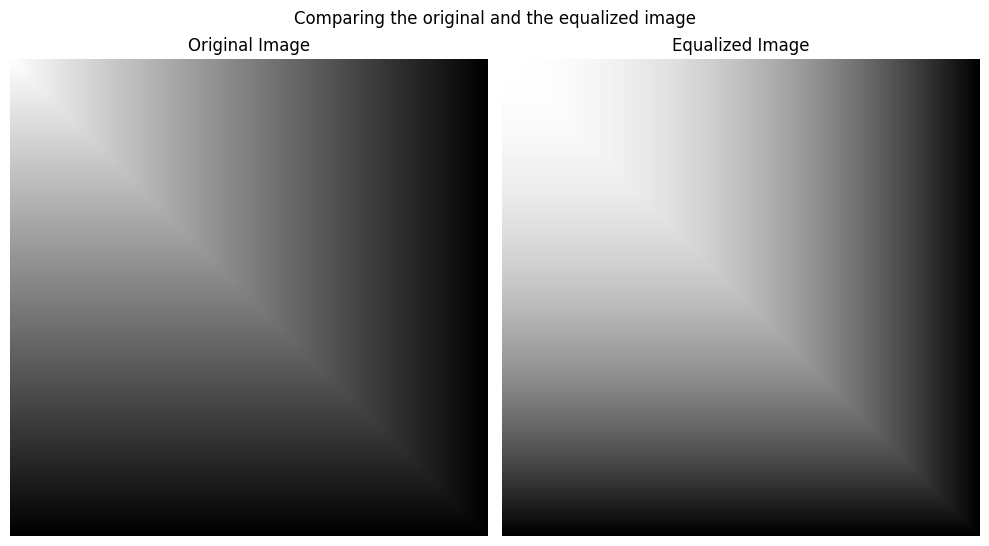

In [ ]:
# @title Equalized histogram and cdf
plt.rcParams["figure.figsize"] = (9,6)
plt.bar(eqhist.keys(),eqhist.values())
plt.tight_layout()
plt.title('Equalized Image')
ccdf = np.cumsum(np.array(list(eqhist.values())))
cddf = ccdf/ccdf[-1]
plt.plot(eqhist.keys(),cddf*max(eqhist.values()),label = 'CDF',color='red')

plt.title('CDF')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
show_comparison(imgs[-1])

###### Similarly, we can do this for a sample image,

<img src="https://i.ibb.co/x56c4gV/imageA.png" width="300" height="300" />

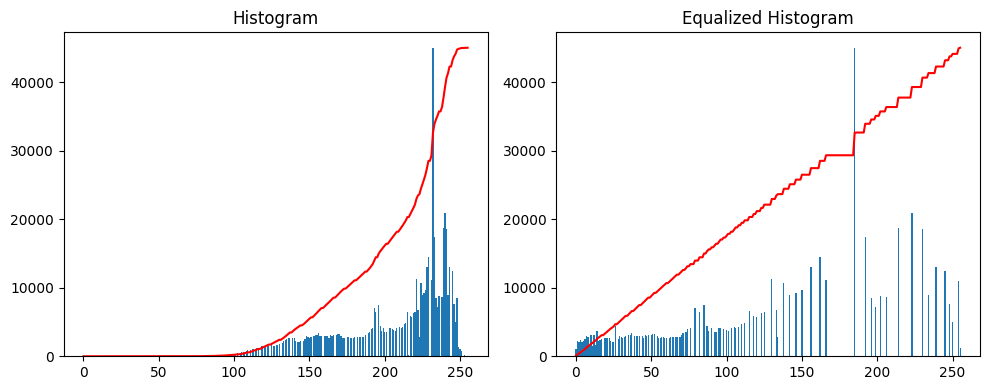

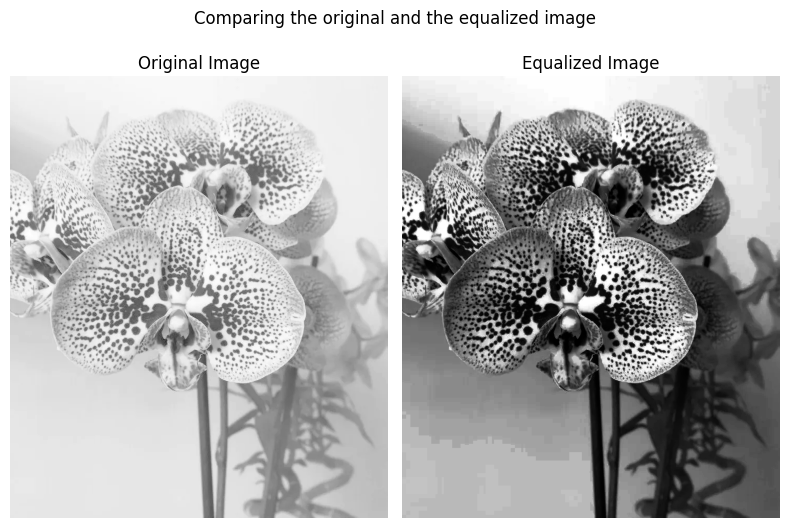

In [ ]:
# @title Example
plt.rcParams["figure.figsize"] = (10,4)
hist,eqhist,og_cdf,scaled_cdf = get_equalized_hist(imgs[-3])
plt.subplot(1,2,1)
plt.bar(hist.keys(),hist.values())
plt.plot(og_cdf.keys(),np.array(list(og_cdf.values()))/max(og_cdf.values())*max(hist.values()),label = 'CDF',color='red')
plt.tight_layout()
plt.title('Histogram')
plt.subplot(1,2,2)
plt.bar(eqhist.keys(),eqhist.values())
plt.tight_layout()
plt.title('Equalized Histogram')

ccdf = np.cumsum(np.array(list(eqhist.values())))
cddf = ccdf/ccdf[-1]
plt.plot(eqhist.keys(),cddf*max(eqhist.values()),label = 'CDF',color='red')

plt.show()
plt.rcParams["figure.figsize"] = (8,6)
show_comparison(imgs[-3])

###### As we can see, the curve has been flattened to include lower intensity values as well.

Now we can do histogram equalization for the images provided in the dataset.

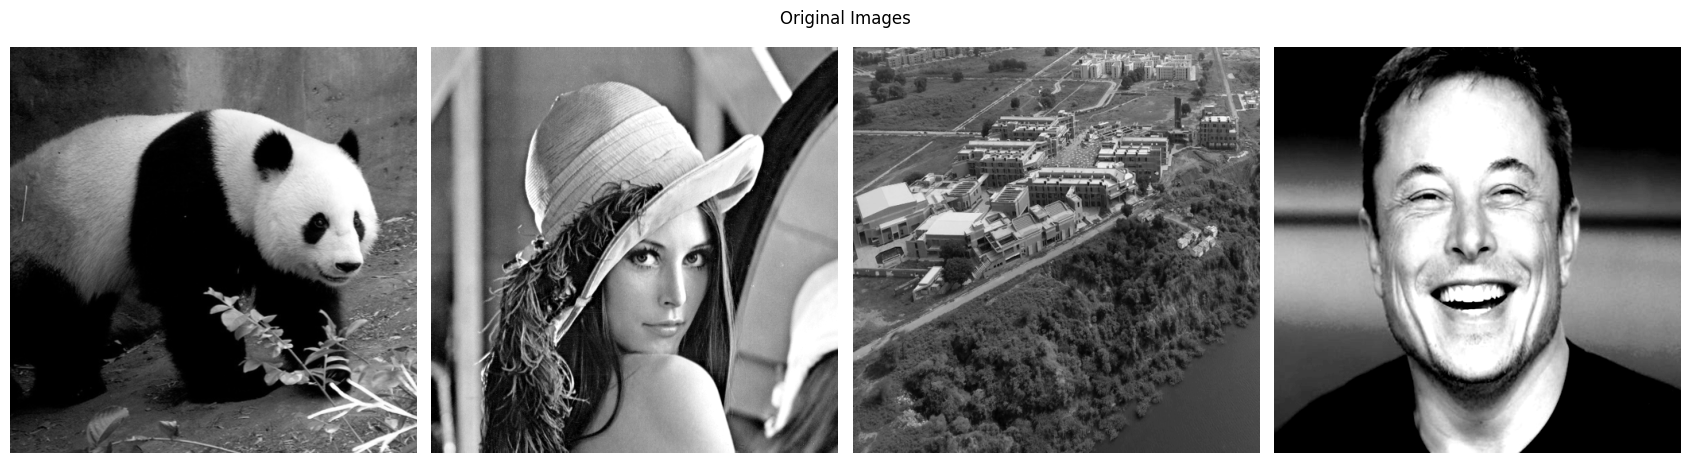

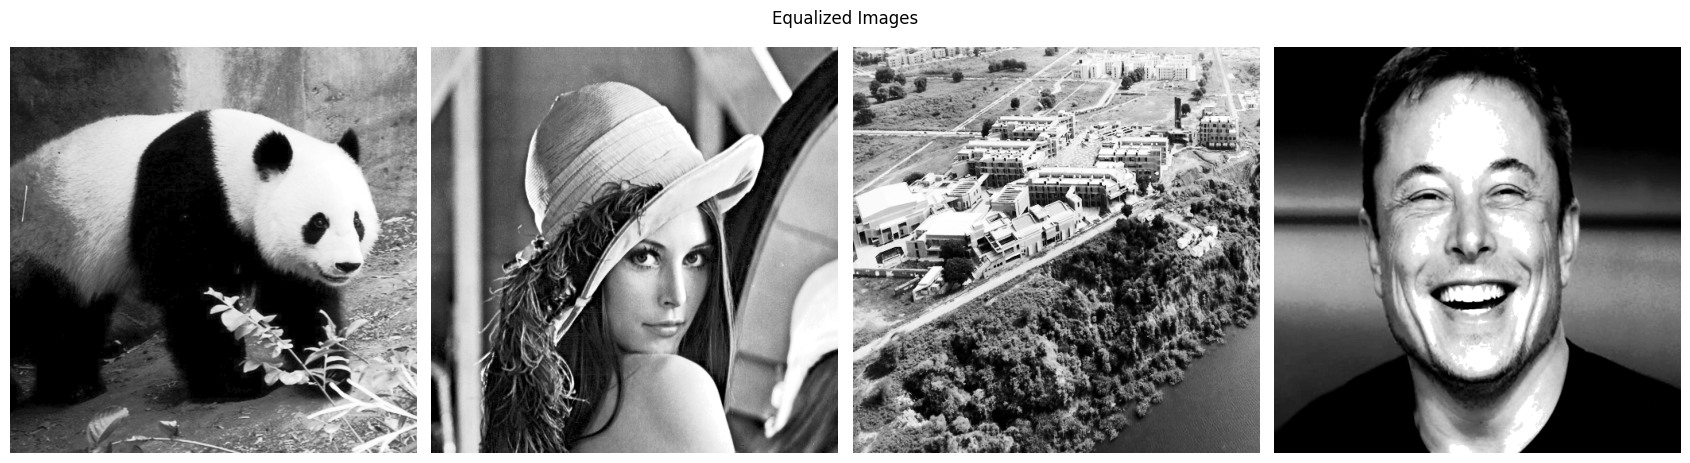

In [ ]:
# @title Dataset Images
show_images(*dataset)
plt.suptitle('Original Images')
plt.show()
equaliized = [get_equalized_image(i) for i in dataset]
print()
show_images(*equaliized)
plt.suptitle('Equalized Images')
plt.show()

### Histogram Matching:

Histogram matching means to transform an image in such a way that its histogram matches with a certain specified histogram (can be of some other image).


###### Example for Histogram Matching

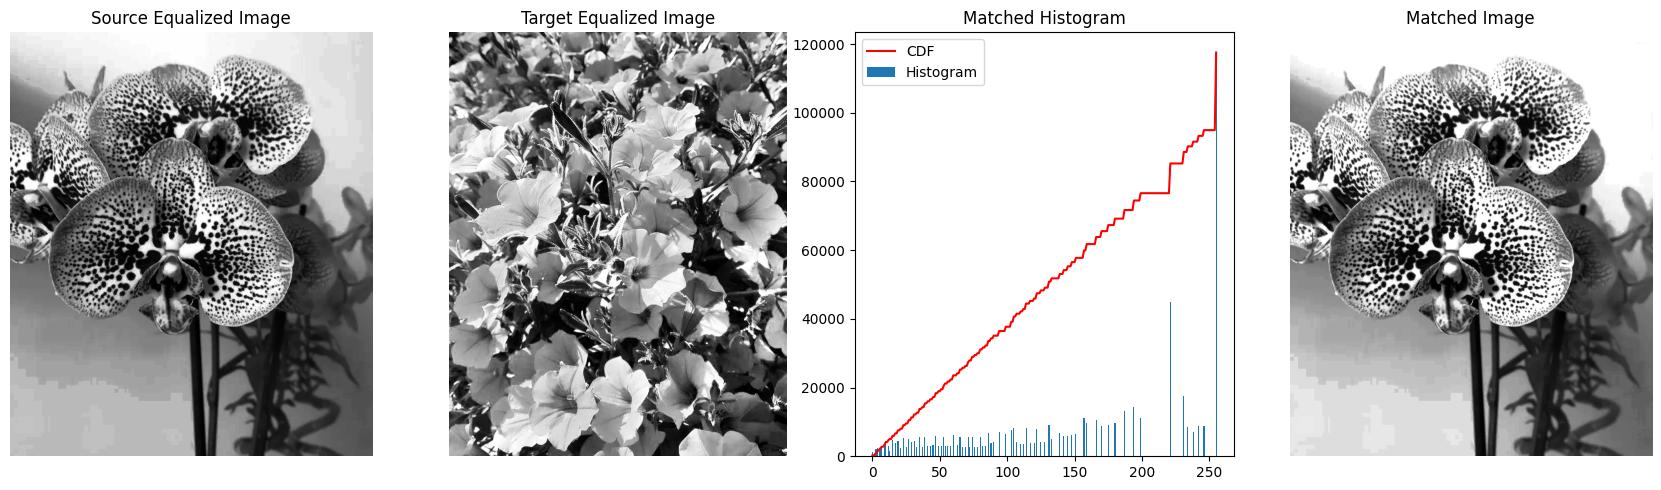

In [ ]:
# @title Histogram Matching with Source and Target Images

dd = [get_equalized_image(i) for i in [imgs[5],imgs[4]]]

matched_img = [dd[0],dd[1],matched(dd[0],dd[1])] #flower many leaves

plt.rcParams["figure.figsize"] = (17,5)
i1,i2,matched_img = matched_img
plt.subplot(1,4,1)
plt.tight_layout()
plt.axis('off')
plt.title('Source Equalized Image')
plt.imshow(i1,cmap = plt.cm.gray)
plt.subplot(1,4,2)
plt.tight_layout()
plt.axis('off')
plt.title('Target Equalized Image')
plt.imshow(i2,cmap = plt.cm.gray)
plt.subplot(1,4,3)
plt.tight_layout()
plt.title('Matched Histogram')
h = get_histogram(matched_img)
plt.bar(h.keys(),h.values(),label='Histogram')
ccdf = np.cumsum(np.array(list(h.values())))
cddf = ccdf/ccdf[-1]
plt.plot(h.keys(),cddf*max(h.values()),label = 'CDF',color='red')
plt.legend()
plt.subplot(1,4,4)
plt.tight_layout()
plt.axis('off')
plt.title('Matched Image')
plt.imshow(matched_img,cmap = plt.cm.gray)
plt.show()

###### Histogram matching for images in dataset

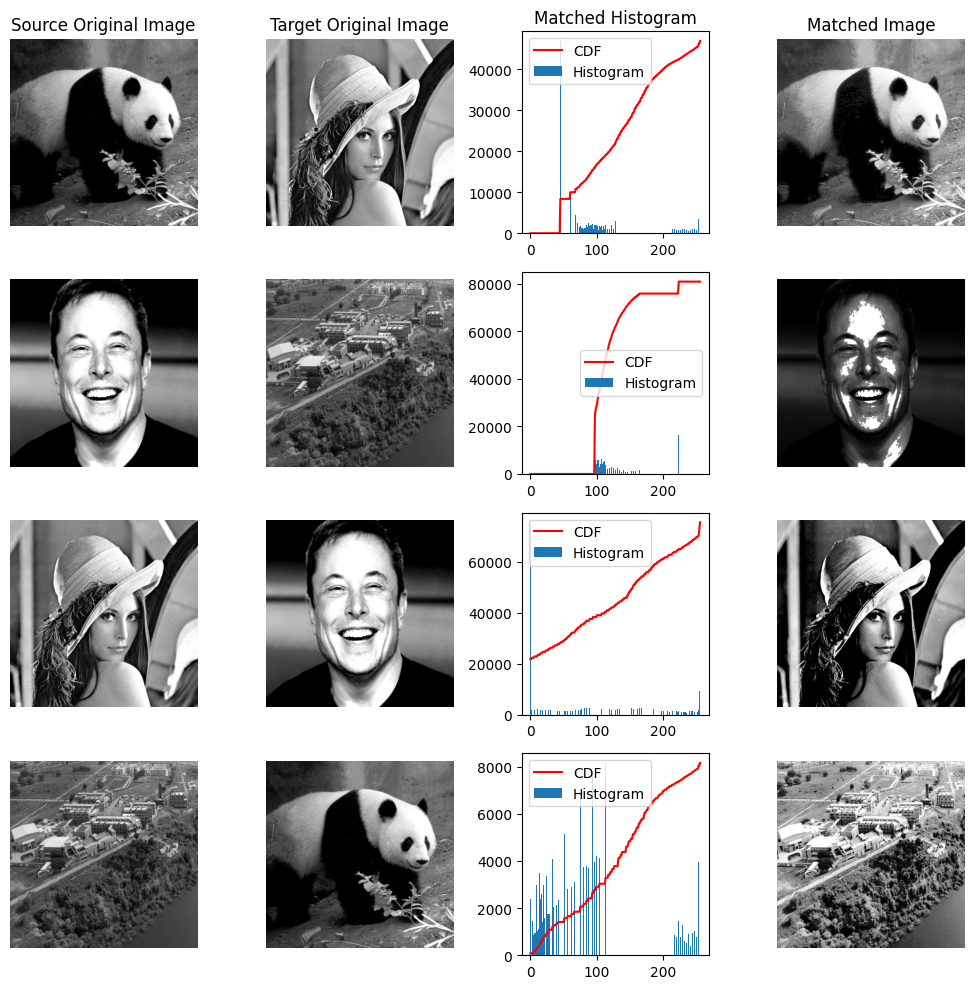

In [ ]:
# @title Histogram Matching with Original Source Image and Original Target Image
matched_imgs = [[dataset[0],dataset[1],matched(dataset[0],dataset[1])], #panda girl
                [dataset[3],dataset[2],matched(dataset[3],dataset[2])], # elon house
                [dataset[1],dataset[3],matched(dataset[1],dataset[3])], # girl elon
                [dataset[2],dataset[0],matched(dataset[2],dataset[1])]] # house panda
plt.rcParams["figure.figsize"] = (10,10)
for i in range(4):
  i1,i2,matched_img = matched_imgs[i]
  plt.subplot(4,4,1+4*i)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Source Original Image')
  plt.imshow(i1,cmap = plt.cm.gray)
  plt.subplot(4,4,2+i*4)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Target Original Image')
  plt.imshow(i2,cmap = plt.cm.gray)
  plt.subplot(4,4,3+4*i)
  plt.tight_layout()
  if i == 0:
    plt.title('Matched Histogram')
  h = get_histogram(matched_img)
  plt.bar(h.keys(),h.values(),label='Histogram')

  ccdf = np.cumsum(np.array(list(h.values())))
  cddf = ccdf/ccdf[-1]
  plt.plot(h.keys(),cddf*max(h.values()),label = 'CDF',color='red')
  plt.legend()

  plt.subplot(4,4,4+4*i)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Matched Image')
  plt.imshow(matched_img,cmap = plt.cm.gray)
plt.show()



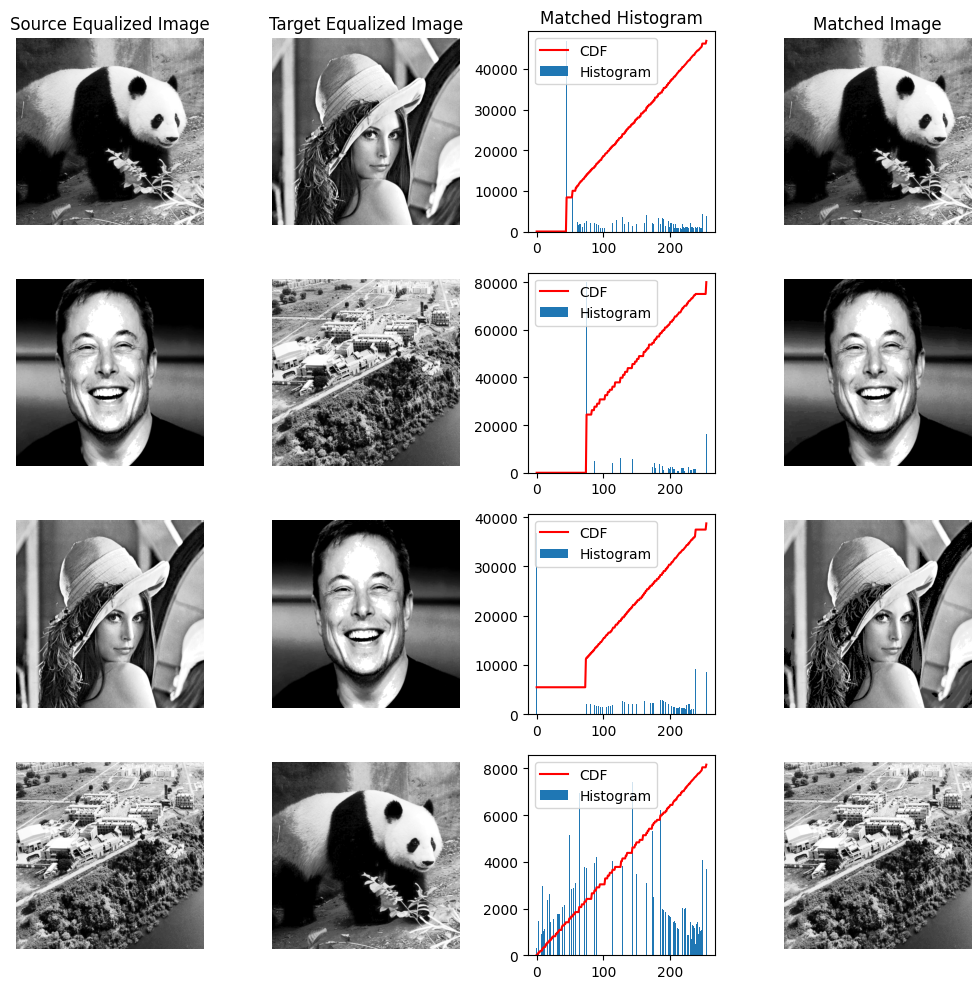

In [ ]:
# @title Histogram Matching with Equalized Source Image and Equalized Target Image

dataset = [get_equalized_image(i) for i in dataset]
matched_imgs = [[dataset[0],dataset[1],matched(dataset[0],dataset[1])], #panda girl
                [dataset[3],dataset[2],matched(dataset[3],dataset[2])], # elon house
                [dataset[1],dataset[3],matched(dataset[1],dataset[3])], # girl elon
                [dataset[2],dataset[0],matched(dataset[2],dataset[1])]] # house panda
plt.rcParams["figure.figsize"] = (10,10)
for i in range(4):
  i1,i2,matched_img = matched_imgs[i]
  plt.subplot(4,4,1+4*i)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Source Equalized Image')
  plt.imshow(i1,cmap = plt.cm.gray)
  plt.subplot(4,4,2+i*4)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Target Equalized Image')
  plt.imshow(i2,cmap = plt.cm.gray)
  plt.subplot(4,4,3+4*i)
  plt.tight_layout()
  if i == 0:
    plt.title('Matched Histogram')
  h = get_histogram(matched_img)
  plt.bar(h.keys(),h.values(),label='Histogram')

  ccdf = np.cumsum(np.array(list(h.values())))
  cddf = ccdf/ccdf[-1]
  plt.plot(h.keys(),cddf*max(h.values()),label = 'CDF',color='red')
  plt.legend()

  plt.subplot(4,4,4+4*i)
  plt.tight_layout()
  plt.axis('off')
  if i == 0:
    plt.title('Matched Image')
  plt.imshow(matched_img,cmap = plt.cm.gray)
plt.show()

### References:

1. S. Sudhakar, “Histogram Equalization,” Medium, Aug. 02, 2017. https://towardsdatascience.com/histogram-equalization-5d1013626e64
2. “Histogram Equalization in Digital Image Processing,” GeeksforGeeks, Nov. 07, 2022. https://www.geeksforgeeks.org/histogram-equalization-in-digital-image-processing/
3. K. S. Htoon, “A Tutorial to Histogram Equalization,” Medium, Aug. 18, 2020. https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2

Discussed it with Faayza Vora (23110109), Karan Sagar Gandhi (23110157), and Hasan Ali (23110133)